#### Imports

In [1]:
import numpy as np
import gradio as gr
from zipfile import ZipFile
import os
import requests
import random
import shutil
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.applications.vgg19 import preprocess_input
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay

C:\Users\teemu\anaconda3\envs\gpu310\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
C:\Users\teemu\anaconda3\envs\gpu310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Download

To use the dataset, you need to download and extract the DIV2K dataset, which contains both training and validation high-resolution images.

This script will automatically download and extract the dataset into a specified directory.

**Important:** Only run this script if you haven't already downloaded or extracted the dataset. If the dataset is already available, you can skip this step.

In [2]:
'''urls = [
    "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip",
    "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip"
]

data_dir = "../loppuprojekti/data"
os.makedirs(data_dir, exist_ok=True)

for url in urls:
    filename = os.path.join(data_dir, os.path.basename(url))
    # Download zip file
    print(f"Downloading {url}...")
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    print("Download ready:", filename)
    # Exctract zip file
    print(f"Extracting {filename}...")
    with ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(data_dir)
    print("Extracted files!")

print("Data pulling ready:", data_dir)'''

'urls = [\n    "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip",\n    "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip"\n]\n\ndata_dir = "../loppuprojekti/data"\nos.makedirs(data_dir, exist_ok=True)\n\nfor url in urls:\n    filename = os.path.join(data_dir, os.path.basename(url))\n    # Download zip file\n    print(f"Downloading {url}...")\n    with requests.get(url, stream=True) as r:\n        r.raise_for_status()\n        with open(filename, \'wb\') as f:\n            for chunk in r.iter_content(chunk_size=8192):\n                f.write(chunk)\n    print("Download ready:", filename)\n    # Exctract zip file\n    print(f"Extracting {filename}...")\n    with ZipFile(filename, \'r\') as zip_ref:\n        zip_ref.extractall(data_dir)\n    print("Extracted files!")\n\nprint("Data pulling ready:", data_dir)'

### Data Preparation

This code splits the training dataset by moving 15% of the images from the training folder into a separate test folder

In [3]:
# For GPU logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

data_dir = "../loppuprojekti/data"
train = "../loppuprojekti/data/DIV2K_train_HR/"
validation = "../loppuprojekti/data/DIV2K_valid_HR/"
test = "../loppuprojekti/data/DIV2K_test_HR"

os.makedirs(test, exist_ok=True)

train_files = os.listdir(train)

num_test_files = int(len(train_files) * 0.15)

files_to_move = random.sample(train_files, num_test_files)

if not os.listdir(test):
    for file in files_to_move:
        src = os.path.join(train, file)
        dst = os.path.join(test, file)
        shutil.move(src, dst)

    print(f"Moved {len(files_to_move)} files to test directory")

else:
    print("Test files already exist")

Test files already exist


#### Data Augmentation Helper Functions

These functions apply random data augmentation techniques to both low-resolution (LR) and high-resolution (HR) images, which helps improve the model's generalization during training.

In [4]:
def flip_left_right(lowres_img, highres_img):
    """Flips Images to left and right."""

    # Outputs random values from a uniform distribution in between 0 to 1
    rn = tf.random.uniform(shape=(), maxval=1.0)

    # If rn is less than 0.5 it returns original lowres_img and highres_img
    # If rn is greater than 0.5 it returns flipped image
    return tf.cond(
        rn < 0.5,
        lambda: (lowres_img, highres_img),
        lambda: (
            tf.image.flip_left_right(lowres_img),
            tf.image.flip_left_right(highres_img),
        ),
    )


def random_rotate(lowres_img, highres_img):
    """Rotates Images by 90 degrees."""

    # Outputs random values from uniform distribution in between 0 to 4
    rn = tf.cast(tf.random.uniform(shape=(), maxval=4, dtype=tf.float32), dtype=tf.int32)

    # Here rn signifies number of times the image(s) are rotated by 90 degrees
    return tf.image.rot90(lowres_img, rn), tf.image.rot90(highres_img, rn)

#### Utility Functions

The code defines a set of helper functions and classes aimed at simplifying model building, training, and evaluation in a deep learning pipeline.

In [5]:
@register_keras_serializable()
class PixelShuffle(layers.Layer):
    def __init__(self, scale, **kwargs):
        super().__init__(**kwargs)
        self.scale = scale

    def call(self, inputs):
        return tf.nn.depth_to_space(inputs, block_size=self.scale)

    def get_config(self):
        config = super().get_config()
        config.update({"scale": self.scale})
        return config

@register_keras_serializable()
def load_model(filepath):
    return keras.models.load_model(
    filepath,
    custom_objects={
        "PixelShuffle": PixelShuffle,
        "combined_loss": combined_loss,
        "PSNR": PSNR,
        "SSIM": SSIM,
        "PiecewiseConstantDecay": PiecewiseConstantDecay
    },
)

@register_keras_serializable()
def PSNR(original, generated):
    return tf.image.psnr(original, generated, max_val=1.0)

@register_keras_serializable()
def SSIM(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

#### Dataset Creation

We create the dataset by applying random cropping to each high-resolution image. While this technique is not ideal for evaluating performance on full-size images, it provides a fast and memory-efficient way to train the model using smaller, diverse patches.

Each cropped patch is:
- Downscaled to simulate a low-resolution version (input).
- Paired with the original high-resolution patch (target).

This setup allows the model to learn super-resolution mappings using small image patches, which significantly reduces computational overhead during training.

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
crop_size = 192
scale = 4

train_dir = os.path.join(data_dir, "DIV2K_train_HR")
val_dir = os.path.join(data_dir, "DIV2K_valid_HR")
test_dir = os.path.join(data_dir, "DIV2K_test_HR")

train_files = [
    os.path.join(train_dir, fname)
    for fname in os.listdir(train_dir)
    if fname.lower().endswith((".png", ".jpg", ".jpeg"))
]

val_files = [
    os.path.join(val_dir, fname)
    for fname in os.listdir(val_dir)
    if fname.lower().endswith((".png", ".jpg", ".jpeg"))
]

test_files = [
    os.path.join(test_dir, fname)
    for fname in os.listdir(test_dir)
    if fname.lower().endswith((".png", ".jpg", ".jpeg"))
]

def random_crop_and_downscale(hr_img):
    hr_patch = tf.image.random_crop(hr_img, size=[crop_size, crop_size, 3])
    hr_patch.set_shape([crop_size, crop_size, 3])
    lr_patch = tf.image.resize(
        hr_patch, [crop_size // scale, crop_size // scale], method="area"
    )
    lr_patch.set_shape([crop_size // scale, crop_size // scale, 3])
    return lr_patch, hr_patch

# Build datasets

def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3)
    return tf.image.convert_image_dtype(img, tf.float32)

train_ds = tf.data.Dataset.from_tensor_slices(train_files).map(
    load_image, num_parallel_calls=tf.data.AUTOTUNE
)


val_ds = tf.data.Dataset.from_tensor_slices(val_files).map(
    load_image, num_parallel_calls=tf.data.AUTOTUNE
)


test_ds = tf.data.Dataset.from_tensor_slices(test_files).map(
    load_image, num_parallel_calls=tf.data.AUTOTUNE
)


# Apply random cropping and downscaling
BATCH_SIZE = 4

train_sr = train_ds.map(random_crop_and_downscale, num_parallel_calls=tf.data.AUTOTUNE)
train_sr = train_sr.map(random_rotate, num_parallel_calls=tf.data.AUTOTUNE)
train_sr = train_sr.map(flip_left_right, num_parallel_calls=tf.data.AUTOTUNE)
train_sr = train_sr.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_sr = val_ds.map(random_crop_and_downscale, num_parallel_calls=tf.data.AUTOTUNE)
val_sr = val_sr.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_sr = test_ds.map(random_crop_and_downscale, num_parallel_calls=tf.data.AUTOTUNE)
test_sr = test_sr.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Example: print shapes

for lr, hr in train_sr.take(1):
    print("LR patch shape:", lr.shape)
    print("HR patch shape:", hr.shape)
#### Plot Example of Training Data

LR patch shape: (4, 48, 48, 3)
HR patch shape: (4, 192, 192, 3)


The image pair below illustrates a low-resolution input and its corresponding high-resolution target, as used across training, validation, and test datasets.

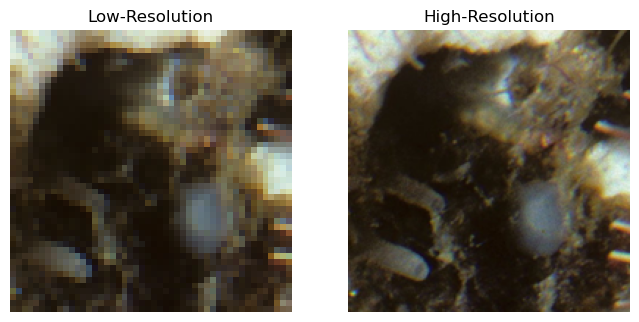

In [7]:
# Get one LR-HR pair from the dataset
for lr, hr in train_sr.take(1):
    lr_img = lr.numpy()
    hr_img = hr.numpy()

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title("Low-Resolution")
    plt.imshow(lr_img[0])
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("High-Resolution")
    plt.imshow(hr_img[0])
    plt.axis("off")

    plt.show()

#### Callbacks

This cell defines training callbacks to improve model performance and prevent overfitting.

In [8]:
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",  # or val_calculate_psnr for PSNR
    patience=20,
    restore_best_weights=True,
    mode='min'
)

early_stop_comb = EarlyStopping(
    monitor="val_SSIM",
    patience=30,
    restore_best_weights=True,
    mode='max'
)

#### Model Construction

Defines the architecture of the super-resolution model, including residual blocks for feature learning and upsampling layers for image resolution enhancement. The `make_model` function builds and returns the full model.

In [9]:
# Residual block layers
def ResBlock(inputs, filters):
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(inputs)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.Add()([inputs, x])
    return x


# Up sampling layer
def Upsampling(inputs, factor=2, **kwargs):
    x = layers.Conv2D(64 * (factor**2), 3, padding="same", **kwargs)(inputs)
    x = PixelShuffle(factor)(x)
    x = layers.Conv2D(64 * (factor**2), 3, padding="same", **kwargs)(x)
    x = PixelShuffle(factor)(x)
    return x


# Model creation function
def make_model(num_filters, num_of_residual_blocks):
    input_layer = layers.Input(shape=(None, None, 3))
    x = x_new = layers.Conv2D(num_filters, 3, padding="same")(input_layer)

    for _ in range(num_of_residual_blocks):
        x_new = ResBlock(x_new, num_filters)

    x_new = layers.Conv2D(num_filters, 3, padding="same")(x_new)
    x = layers.Add()([x, x_new])

    x = Upsampling(x, factor=2)
    x = layers.Conv2D(3, 3, padding="same")(x)

    output_layer = layers.Activation("sigmoid")(x)
    return Model(inputs=input_layer, outputs=output_layer)


model = make_model(num_filters=256, num_of_residual_blocks=18)

**Phase 1 – Pretraining with MAE Loss**

We first train the model using the mean absolute error (MAE) loss. This phase helps the model learn a strong baseline for low-level reconstruction.

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss="mae", metrics=[PSNR, SSIM])
model.fit(
    train_sr, validation_data=val_sr, epochs=300, callbacks=[early_stop, reduce_lr]
)
model.save_weights("mae.weights.h5")

In [22]:
phase1test = model.evaluate(test_sr, verbose=0)
metric_names = model.metrics_names

print("Phase – 1 evaluation:")
for idx, value in enumerate(phase1test):
    print(f"{metric_names[idx]}: {value}")

Phase – 1 evaluation:
loss: 0.07694196701049805
PSNR: 28.561582565307617
SSIM: 0.7598211169242859


**Phase 2 – Fine-tuning**

After training with MAE loss, we resume training using a more complex combined loss that includes a small perceptual term based on VGG features. This helps the model not only match pixel values but also produce sharper, more natural-looking images.

In [11]:
# Perceptual loss with VGG
vgg = keras.applications.VGG19(include_top=False, weights="imagenet")
vgg.trainable = False
vgg_model = Model(inputs=vgg.input, outputs=vgg.get_layer("block3_conv3").output)


def preprocess_vgg(x):
    x = tf.image.resize(x, [224, 224])
    x = preprocess_input(x * 255.0)
    return x

def combined_loss(y_true, y_pred):
    # Preprocess for VGG
    y_true_vgg = preprocess_vgg(y_true)
    y_pred_vgg = preprocess_vgg(y_pred)

    # Extract features
    f_true = vgg_model(y_true_vgg)
    f_pred = vgg_model(y_pred_vgg)

    # Perceptual loss: feature-wise MSE
    perceptual = tf.reduce_mean(tf.square(f_true - f_pred))
    pixel = tf.reduce_mean(tf.abs(y_true - y_pred))
    return 0.000001 * perceptual + 1.0 * pixel

model.load_weights('mae.weights.h5')
model.compile(optimizer=Adam(learning_rate=1e-4), loss=combined_loss, metrics=[PSNR, SSIM])
history = model.fit(train_sr, validation_data=val_sr, epochs=300, callbacks=[early_stop_comb, reduce_lr])
model.save('super_resolution_model.keras')

model.evaluate(test_sr)

Epoch 1/300


NotFoundError: Graph execution error:

Detected at node 'combined_loss/model_1/block1_conv1/Relu_1' defined at (most recent call last):
    File "C:\Users\teemu\anaconda3\envs\gpu310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\teemu\anaconda3\envs\gpu310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\teemu\anaconda3\envs\gpu310\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "C:\Users\teemu\anaconda3\envs\gpu310\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "C:\Users\teemu\anaconda3\envs\gpu310\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "C:\Users\teemu\anaconda3\envs\gpu310\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\teemu\anaconda3\envs\gpu310\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Users\teemu\anaconda3\envs\gpu310\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "C:\Users\teemu\anaconda3\envs\gpu310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\teemu\anaconda3\envs\gpu310\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "C:\Users\teemu\anaconda3\envs\gpu310\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "C:\Users\teemu\anaconda3\envs\gpu310\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "C:\Users\teemu\anaconda3\envs\gpu310\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "C:\Users\teemu\anaconda3\envs\gpu310\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "C:\Users\teemu\anaconda3\envs\gpu310\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "C:\Users\teemu\anaconda3\envs\gpu310\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\teemu\anaconda3\envs\gpu310\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "C:\Users\teemu\anaconda3\envs\gpu310\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "C:\Users\teemu\anaconda3\envs\gpu310\lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\teemu\anaconda3\envs\gpu310\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\teemu\anaconda3\envs\gpu310\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\teemu\anaconda3\envs\gpu310\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\teemu\AppData\Local\Temp\ipykernel_16924\1651420808.py", line 28, in <module>
      history = model.fit(train_sr, validation_data=val_sr, epochs=300, callbacks=[early_stop_comb, reduce_lr])
    File "C:\Users\teemu\anaconda3\envs\gpu310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\teemu\anaconda3\envs\gpu310\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\teemu\anaconda3\envs\gpu310\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\teemu\anaconda3\envs\gpu310\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\teemu\anaconda3\envs\gpu310\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\teemu\anaconda3\envs\gpu310\lib\site-packages\keras\engine\training.py", line 994, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\teemu\anaconda3\envs\gpu310\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
      return self.compiled_loss(
    File "C:\Users\teemu\anaconda3\envs\gpu310\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\teemu\anaconda3\envs\gpu310\lib\site-packages\keras\losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "C:\Users\teemu\anaconda3\envs\gpu310\lib\site-packages\keras\losses.py", line 272, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\teemu\AppData\Local\Temp\ipykernel_16924\1651420808.py", line 19, in combined_loss
      f_pred = vgg_model(y_pred_vgg)
    File "C:\Users\teemu\anaconda3\envs\gpu310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\teemu\anaconda3\envs\gpu310\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\teemu\anaconda3\envs\gpu310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\teemu\anaconda3\envs\gpu310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\teemu\anaconda3\envs\gpu310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\teemu\anaconda3\envs\gpu310\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\teemu\anaconda3\envs\gpu310\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\teemu\anaconda3\envs\gpu310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\teemu\anaconda3\envs\gpu310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\teemu\anaconda3\envs\gpu310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\teemu\anaconda3\envs\gpu310\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "C:\Users\teemu\anaconda3\envs\gpu310\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "C:\Users\teemu\anaconda3\envs\gpu310\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'combined_loss/model_1/block1_conv1/Relu_1'
No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine 1#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 1: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 0#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 0: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 2#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 38453248 bytes.
  Profiling failure on CUDNN engine 2: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 38453248 bytes.
  Profiling failure on CUDNN engine 4#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 152050432 bytes.
  Profiling failure on CUDNN engine 4: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 152050432 bytes.
  Profiling failure on CUDNN engine 6#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16818176 bytes.
  Profiling failure on CUDNN engine 6: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16818176 bytes.
  Profiling failure on CUDNN engine 5#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 19945472 bytes.
  Profiling failure on CUDNN engine 5: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 19945472 bytes.
  Profiling failure on CUDNN engine 7#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 500902912 bytes.
  Profiling failure on CUDNN engine 7: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 500902912 bytes.
	 [[{{node combined_loss/model_1/block1_conv1/Relu_1}}]] [Op:__inference_train_function_79729]

In [ ]:
phase2test = model.evaluate(test_sr, verbose=0)
metric_names = model.metrics_names
for idx, value in enumerate(phase2test):
    print(f"{metric_names[idx]}: {value}")

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()


# Bigger the PSNR value is, more prediction and original high res images are same
plt.figure(figsize=(8, 4))
plt.plot(history.history['PSNR'], label='Train PSNR')
plt.plot(history.history['val_PSNR'], label='Validation PSNR')
plt.title('Model PSNR')
plt.ylabel('PSNR')
plt.xlabel('Epoch')
plt.legend()

plt.show()

#### Test

This block demonstrates how the model performs super-resolution on a degraded full-size image.

To simulate a low-resolution image:
- The original high-resolution image is downscaled using area interpolation (which preserves structural detail).
- It is then upscaled back to the original size using nearest-neighbor interpolation, introducing visible blockiness and pixelation.
- This artificially degraded image is fed into the model to generate a super-resolved output.

In [ ]:
N = 7
for i, hr_img in enumerate(test_ds):
    if i == N:
        hr_img = hr_img.numpy()
        break

# Convert image to bad quality
scale = 6
h, w = hr_img.shape[0], hr_img.shape[1]
lr_img = tf.image.resize(hr_img, [h // scale, w // scale], method="area")
lr_img_blocky = tf.image.resize(lr_img, [h, w], method="nearest").numpy()

# Predict super-resolution image
lr_input = np.expand_dims(lr_img, axis=0)
sr_img = model.predict(lr_input)

# Post-process output image
sr_img = np.squeeze(sr_img, axis=0)
sr_img_disp = np.clip(sr_img * 255.0, 0, 255).astype(np.uint8)

# Convert HR and LR images for display
hr_img_disp = np.clip(hr_img * 255, 0, 255).astype("uint8")
lr_img_disp = np.clip(lr_img_blocky * 255, 0, 255).astype("uint8")

# Plot the images
plt.figure(figsize=(18, 18))

plt.subplot(3, 1, 1)
plt.title("Low-Resolution (Native Size)", fontsize=20)
plt.imshow(lr_img_disp, interpolation='nearest')
plt.axis("off")

plt.subplot(3, 1, 2)
plt.title("Super-Resolution", fontsize=20)
plt.imshow(sr_img_disp)
plt.axis("off")

plt.subplot(3, 1, 3)
plt.title("High-Resolution (Original)", fontsize=20)
plt.imshow(hr_img_disp)
plt.axis("off")

plt.tight_layout()
plt.show()


#### Model demo

In this section, we create a simple UI using Gradio to demonstrate the functionality of the super-resolution model.

**Prerequisites**

Before running the demo, make sure to run the following cells first:
- `Imports`
- `Utility functions`
- `Preprocessing helper functions`

---

**Setup and Configuration:**


The model was trained, saved and loaded using a GPU environment with the following setup:

  - **Python**: 3.10.16
  - **Keras**: 2.10.0
  - **TensorFlow**: 2.10.1
  - **NumPy**: 1.26.4

Attempts to load the model in a different interpreter (with newer versions of Python, TensorFlow, or Keras) failed — likely due to version incompatibilities between these libraries. Additionally, newer versions of NumPy caused import errors in this setup.

**Note**: If you're unable to run this cell, ensure your environment matches the configuration above to avoid compatibility issues when loading the model.

In [ ]:
def super_resolve_large_image(model, input_img, patch_size=256, overlap=32):
    """
    Super-resolve a large image by tiling it into patches.
    Args:
        model: Trained super-resolution model.
        input_img: NumPy array, shape (H, W, 3), float32 in [0,1].
        patch_size: Size of each patch to process.
        overlap: Overlap between patches to avoid seams.
    Returns:
        Super-resolved image as NumPy array.
    """
    h, w, c = input_img.shape
    scale = 4  # Change if your model uses a different scale

    out_h, out_w = h * scale, w * scale
    output_img = np.zeros((out_h, out_w, c), dtype=np.float32)
    weight_mask = np.zeros((out_h, out_w, c), dtype=np.float32)

    stride = patch_size - overlap
    for y in range(0, h, stride):
        for x in range(0, w, stride):
            patch = input_img[y : y + patch_size, x : x + patch_size, :]
            patch_h, patch_w = patch.shape[:2]
            patch_input = np.expand_dims(patch, axis=0)
            sr_patch = model.predict(patch_input)[0]
            y1, x1 = y * scale, x * scale
            y2, x2 = y1 + patch_h * scale, x1 + patch_w * scale
            output_img[y1:y2, x1:x2, :] += sr_patch[
                : patch_h * scale, : patch_w * scale, :
            ]
            weight_mask[y1:y2, x1:x2, :] += 1.0

    # Avoid division by zero
    output_img /= np.maximum(weight_mask, 1e-8)
    return np.clip(output_img, 0, 1)


saved_model = load_model("super_resolution_model.keras")


def superRes(input_img):

    img_array = input_img.astype(np.float32) / 255.0
    sr_img = super_resolve_large_image(
        saved_model, img_array, patch_size=256, overlap=32
    )
    return (sr_img * 255).astype(np.uint8)



demo = gr.Interface(fn=superRes, inputs=gr.Image(type="numpy"), outputs="image")



if __name__ == "__main__":


    demo.launch(share=True)